# Predict household income from satellite imagery data

First pass. TRY ONE MODEL

General ML pipeline steps:
1. Import data
2. Split data into test/train sets
3. Preprocess test/train sets separately
4. Generate features from data
5. For each regressor-hyperparameter combination:
    - Train regressor with given hyperparameters and training data and labels
    - Generate predicted labels for test data with trained regressor
    - Evaluate regressor-hyperparameter performance against actual test labels and get $R^2$
6. Explore best-performing models

In [58]:
import os
import math
import pickle
import numpy as np
import pandas as pd 

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score

# Import configuration file
import config as cf

# Display options 
pd.options.display.max_columns = 999
pd.options.display.max_colwidth = -1

# Turn off big pink warnings
import warnings
warnings.filterwarnings('ignore')

# Data file path 
final_data_file_path = "/Users/robmarty/Dropbox/World Bank/IEs/Pakistan Poverty Estimation from Satellites/Data/FinalData"
#

## 1. Import data and drop "future" rows

In [59]:
DATA_PATH = os.path.join(final_data_file_path, 'Outputs for Analysis TEMP', 'bisp_sat_inc_data.csv')
df = pd.read_csv(DATA_PATH)
df.shape

(5416, 46)

In [60]:
df.head()

,uid,viirs_2012,viirs_2013,viirs_2014,viirs_2015,viirs_2016,viirs_2017,viirs_2018,dmspols_1992,dmspols_1993,dmspols_1994,dmspols_1995,dmspols_1996,dmspols_1997,dmspols_1998,dmspols_1999,dmspols_2000,dmspols_2001,dmspols_2002,dmspols_2003,dmspols_2004,dmspols_2005,dmspols_2006,dmspols_2007,dmspols_2008,dmspols_2009,dmspols_2010,dmspols_2011,dmspols_2012,dmspols_2013,l7_2011_1,l7_2011_2,l7_2011_3,l7_2011_4,l7_2011_5,l7_2011_6,l7_2011_7,l7_2013_1,l7_2013_2,l7_2013_3,l7_2013_4,l7_2013_5,l7_2013_6,l7_2013_7,hhinc_2011,hhinc_2013
0,100389,2.052018,2.141392,2.089507,2.307763,2.850603,3.653005,3.750000,43.0,33.666667,35.50,45.333333,40.0,33.166667,39.50,40.333333,37.333333,39.666667,38.833333,33.666667,34.00,34.50,40.666667,45.00,43.0,30.333333,46.0,32.666667,47.666667,45.333333,902.331348,1224.739396,1393.123911,2555.792708,2474.174317,3005.856769,1922.539802,951.897734,1282.748257,1417.251598,2574.000436,2469.137711,3000.408919,1889.609384,9000.0,73000.0
1,100401,1.964332,2.133366,2.052437,2.296554,2.769960,3.702374,3.488333,43.0,33.666667,35.50,45.333333,40.0,33.166667,39.50,40.333333,37.333333,39.666667,38.833333,33.666667,34.00,34.50,40.666667,45.00,43.0,30.333333,46.0,32.666667,47.666667,45.333333,885.841488,1200.548350,1366.253764,2512.672843,2451.849595,3004.616242,1890.566155,941.063694,1268.392009,1402.777070,2547.212362,2463.117111,2998.701940,1876.871453,75000.0,159000.0
2,100581,1.824753,1.937131,1.875487,2.047540,2.557241,3.198625,3.286000,43.0,32.500000,34.25,43.000000,38.0,31.750000,38.25,38.750000,36.000000,38.250000,37.750000,32.000000,32.75,33.75,40.000000,43.75,42.5,30.000000,45.5,30.500000,47.500000,44.500000,886.021385,1206.745127,1373.031277,2550.999418,2462.909660,3006.164678,1900.649840,935.162060,1263.157696,1398.079866,2572.847832,2458.750073,2999.056008,1880.909223,48000.0,0.0
3,101101,1.964332,2.133366,2.052437,2.296554,2.769960,3.702374,3.488333,43.0,33.666667,35.50,45.333333,40.0,33.166667,39.50,40.333333,37.333333,39.666667,38.833333,33.666667,34.00,34.50,40.666667,45.00,43.0,30.333333,46.0,32.666667,47.666667,45.333333,886.196798,1201.037263,1366.468559,2514.479913,2450.865939,3004.699563,1890.108734,940.979913,1268.248763,1401.871616,2547.740466,2459.946143,2998.786463,1874.074672,31200.0,219000.0
4,101236,2.052018,2.141392,2.089507,2.307763,2.850603,3.653005,3.750000,43.0,33.666667,35.50,45.333333,40.0,33.166667,39.50,40.333333,37.333333,39.666667,38.833333,33.666667,34.00,34.50,40.666667,45.00,43.0,30.333333,46.0,32.666667,47.666667,45.333333,891.264553,1209.613090,1374.709528,2535.919345,2453.881552,3005.134086,1897.493484,943.113959,1271.824645,1403.386186,2563.689111,2453.279467,2999.725311,1869.047929,14000.0,NaN


In [61]:
# Remove NAs
df = df.loc[(df['hhinc_2011'] >= 0)]
df = df.loc[(df['hhinc_2011'] <= 20000000)]

In [62]:
# DV as Quantiles
df['hhinc_2011'] = pd.qcut(df['hhinc_2011'], 3, labels=False)
df['hhinc_2011'].value_counts()

0    1663
1    1613
2    1590
Name: hhinc_2011, dtype: int64

In [63]:
# Keep only 2011 columns, but include viirs_2012
df = df.filter(regex='_2011', axis=1).join(df['viirs_2012'])
df.head()

,dmspols_2011,l7_2011_1,l7_2011_2,l7_2011_3,l7_2011_4,l7_2011_5,l7_2011_6,l7_2011_7,hhinc_2011,viirs_2012
0,32.666667,902.331348,1224.739396,1393.123911,2555.792708,2474.174317,3005.856769,1922.539802,0,2.052018
1,32.666667,885.841488,1200.548350,1366.253764,2512.672843,2451.849595,3004.616242,1890.566155,1,1.964332
2,30.500000,886.021385,1206.745127,1373.031277,2550.999418,2462.909660,3006.164678,1900.649840,1,1.824753
3,32.666667,886.196798,1201.037263,1366.468559,2514.479913,2450.865939,3004.699563,1890.108734,0,1.964332
4,32.666667,891.264553,1209.613090,1374.709528,2535.919345,2453.881552,3005.134086,1897.493484,0,2.052018


In [64]:
# Drop columns where the label is missing
df = df.loc[~pd.isnull(df['hhinc_2011'])]

df.shape

(4866, 10)

## 2. Split data into test/train

In [65]:
LABEL = 'hhinc_2011'
TEST_SIZE = 0.3

# Separate feature sets from label sets
x_df = df.drop(labels=[LABEL], axis=1)
y_df = df[LABEL]

# Split into test and train sets for features and labels
x_train, x_test, y_train, y_test =  train_test_split(x_df, y_df, test_size=TEST_SIZE)

## 3. Preprocess data

All vars are numeric - impute missing data with mean

In [66]:
# Check how many rows are missing across columns
print("TRAINING FEATURES MISSING:")
print(pd.isnull(x_train).sum())
print("")
print("TEST FEATURES MISSING:")
print(pd.isnull(x_test).sum())

TRAINING FEATURES MISSING:
dmspols_2011    33
l7_2011_1       0 
l7_2011_2       0 
l7_2011_3       0 
l7_2011_4       0 
l7_2011_5       0 
l7_2011_6       0 
l7_2011_7       0 
viirs_2012      33
dtype: int64

TEST FEATURES MISSING:
dmspols_2011    19
l7_2011_1       0 
l7_2011_2       0 
l7_2011_3       0 
l7_2011_4       0 
l7_2011_5       0 
l7_2011_6       0 
l7_2011_7       0 
viirs_2012      19
dtype: int64


In [67]:
for i in (x_train, x_test):
    for j in i.columns:
        
        if i[j].isnull().sum():
            # Create imputed flag
            new_name = i[j].name + '_imputed'
            i[new_name] = pd.isnull(i[j]).astype('int')
            # Fill with mean
            i[j] = i[j].fillna(i[j].mean())
        else:
            continue

In [68]:
# All missing values were imputed
print("TRAINING FEATURES MISSING:")
print(pd.isnull(x_train).sum())
print("")
print("TEST FEATURES MISSING:")
print(pd.isnull(x_test).sum())

TRAINING FEATURES MISSING:
dmspols_2011            0
l7_2011_1               0
l7_2011_2               0
l7_2011_3               0
l7_2011_4               0
l7_2011_5               0
l7_2011_6               0
l7_2011_7               0
viirs_2012              0
dmspols_2011_imputed    0
viirs_2012_imputed      0
dtype: int64

TEST FEATURES MISSING:
dmspols_2011            0
l7_2011_1               0
l7_2011_2               0
l7_2011_3               0
l7_2011_4               0
l7_2011_5               0
l7_2011_6               0
l7_2011_7               0
viirs_2012              0
dmspols_2011_imputed    0
viirs_2012_imputed      0
dtype: int64


## 4. Feature Generation

[Landsat 7 specs](https://landsat.usgs.gov/sites/default/files/documents/si_product_guide.pdf#page=14)

Create indices from every possible pair of Landsat 7 band.
- Normalized Difference Vegetation Index, NDVI = $\frac{NIR - Red}{NIR + Red}$ is formed from the (NIR, Red) pair.
- Normalized Difference Built-up Index, NDBI = $\frac{SWIR1 - NIR}{SWIR1 + NIR}$ is formed from the (NIR, SWIR1) pair.
- Normalized Difference Water Index, NDWO = $\frac{NIR - SWIR1}{NIR + SWIR1}$ is also formed from the (NIR, SWIR1) pair.
- Modified NDWI, MNDWI = $\frac{Green - SWIR1}{Green + SWIR1}$ is formed from the (NIR, Green) pair. And so on.


| Band | 1 | 2 | 3 | 4 | 5 | 6 | 7
| ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- 
| 1 | NA 
| 2 | ? | NA 
| 3 | ? | ? | NA 
| 4 | ? | ? | NDVI | NA
| 5 | ? | MNDWI | ? | NDBI, NDWI | NA 
| 6 | ? | ? | ? | ? | ? | NA 
| 7 | ? | ? | ? | ? | ? | ? | NA



In [69]:
# Create ratios 
# Note that ratio of Band A to Band B is the same as ratio of Band B to Band A
# Solution: only create ratios where A < B
for df in (x_train, x_test):
    for i in range(1, 8):
        for j in range(1, 8):

            if i >= j:
                continue
            else:
                band1 = f'l7_2011_{i}'
                band2 = f'l7_2011_{j}'
                new_var = f'ratio_{i}_{j}'
                df[new_var] = abs((df[band1] - df[band2]) / (df[band1] + df[band2]))

In [70]:
x_train.head()

,dmspols_2011,l7_2011_1,l7_2011_2,l7_2011_3,l7_2011_4,l7_2011_5,l7_2011_6,l7_2011_7,viirs_2012,dmspols_2011_imputed,viirs_2012_imputed,ratio_1_2,ratio_1_3,ratio_1_4,ratio_1_5,ratio_1_6,ratio_1_7,ratio_2_3,ratio_2_4,ratio_2_5,ratio_2_6,ratio_2_7,ratio_3_4,ratio_3_5,ratio_3_6,ratio_3_7,ratio_4_5,ratio_4_6,ratio_4_7,ratio_5_6,ratio_5_7,ratio_6_7
4354,5.000000,663.352404,839.831547,932.490440,2097.267092,1844.288239,2963.479432,1300.093279,0.621399,0,0,0.117404,0.168649,0.519418,0.470935,0.634197,0.324298,0.052281,0.428122,0.374222,0.558368,0.215083,0.384446,0.328365,0.521305,0.164654,0.064182,0.171163,0.234645,0.232788,0.173069,0.390139
4852,51.333333,1162.793008,1586.023789,1862.986655,2957.221932,2940.652742,3027.913983,2320.204671,9.114965,0,0,0.153968,0.231409,0.435539,0.433260,0.445061,0.332303,0.080302,0.301810,0.299255,0.312508,0.187951,0.227010,0.224344,0.238183,0.109299,0.002809,0.011811,0.120706,0.014620,0.117937,0.132329
2218,12.000000,935.686485,1269.477088,1449.075406,2524.267111,2216.491009,3025.684745,1712.955336,0.599246,0,0,0.151368,0.215279,0.459134,0.406324,0.527595,0.293459,0.066064,0.330752,0.271665,0.408880,0.148697,0.270601,0.209358,0.352334,0.083453,0.064921,0.090346,0.191473,0.154362,0.128144,0.277027
2375,53.500000,1172.543023,1555.989826,1801.600872,2590.882703,2593.970930,3038.220494,2169.764826,10.741064,0,0,0.140532,0.211509,0.376875,0.377386,0.443073,0.298363,0.073151,0.249560,0.250118,0.322630,0.164738,0.179689,0.180266,0.255509,0.092705,0.000596,0.079469,0.088458,0.078877,0.089049,0.166755
2568,27.500000,886.176189,1148.435035,1253.862239,2678.113399,2039.065110,3023.289733,1387.648202,1.835023,0,0,0.128899,0.171813,0.502747,0.394118,0.546651,0.220541,0.043886,0.399754,0.279413,0.449420,0.094324,0.362223,0.238451,0.413693,0.050648,0.135473,0.060542,0.317398,0.194420,0.190100,0.370815


In [71]:
x_test.head()

,dmspols_2011,l7_2011_1,l7_2011_2,l7_2011_3,l7_2011_4,l7_2011_5,l7_2011_6,l7_2011_7,viirs_2012,dmspols_2011_imputed,viirs_2012_imputed,ratio_1_2,ratio_1_3,ratio_1_4,ratio_1_5,ratio_1_6,ratio_1_7,ratio_2_3,ratio_2_4,ratio_2_5,ratio_2_6,ratio_2_7,ratio_3_4,ratio_3_5,ratio_3_6,ratio_3_7,ratio_4_5,ratio_4_6,ratio_4_7,ratio_5_6,ratio_5_7,ratio_6_7
4998,3.0,1300.269365,1775.359298,2151.357122,2809.231941,3573.917900,2987.841166,3070.125907,0.252893,0,0,0.154469,0.246576,0.367189,0.466467,0.393547,0.404965,0.095754,0.225510,0.336225,0.254552,0.267211,0.132620,0.248470,0.162765,0.175959,0.119798,0.030810,0.044375,0.089317,0.075826,0.013583
3250,6.5,1234.099767,1666.748034,1884.425138,2792.785028,2639.987475,3050.135304,2064.540489,0.642527,0,0,0.149145,0.208536,0.387070,0.362895,0.423888,0.251752,0.061297,0.252501,0.225981,0.293284,0.106610,0.194210,0.166997,0.236234,0.045611,0.028125,0.044045,0.149927,0.072081,0.122318,0.192699
2640,63.0,1360.014472,1791.255282,2084.680318,2502.152098,2816.817221,3032.591896,2490.558900,33.598464,0,0,0.136847,0.210372,0.295725,0.348782,0.380771,0.293604,0.075704,0.165579,0.222558,0.257333,0.163319,0.091015,0.149370,0.185238,0.088712,0.059159,0.095838,0.002322,0.036888,0.061473,0.098138
2340,37.0,1021.280285,1329.252766,1506.775772,2218.192487,2201.716511,3016.215929,1750.821200,3.872381,0,0,0.131022,0.192043,0.369477,0.366254,0.494102,0.263173,0.062596,0.250586,0.247089,0.388212,0.136870,0.190986,0.187392,0.333726,0.074916,0.003728,0.152457,0.117755,0.156096,0.114077,0.265447
3298,7.5,852.557267,1103.729651,1105.880523,2382.576163,1609.865116,2996.909302,1005.775145,0.626091,0,0,0.128392,0.129350,0.472938,0.307546,0.557052,0.082449,0.000973,0.366820,0.186518,0.461679,0.046435,0.365977,0.185579,0.460913,0.047406,0.193543,0.114199,0.406334,0.301088,0.230953,0.497450


In [72]:
# check that lengths match
print(len(x_train) == len(y_train))
print(len(x_test) == len(y_test))

True
True


### 4.1 Define feature groups

1. Daytime-only: Landsat 7 band data and computed indices
2. Nighttime-only: DMSP and VIIRS data + imputed flags
3. All features

In [73]:
DAY_FEATURES = df.filter(regex='l7|ratio', axis=1).columns.tolist()
NIGHT_FEATURES = ['dmspols_2011', 'viirs_2012', 'dmspols_2011_imputed', 'viirs_2012_imputed']
ALL_FEATURES = df.columns.tolist()

print("Day-only:", DAY_FEATURES)
print("-----")
print("Night-only:", NIGHT_FEATURES)

Day-only: ['l7_2011_1', 'l7_2011_2', 'l7_2011_3', 'l7_2011_4', 'l7_2011_5', 'l7_2011_6', 'l7_2011_7', 'ratio_1_2', 'ratio_1_3', 'ratio_1_4', 'ratio_1_5', 'ratio_1_6', 'ratio_1_7', 'ratio_2_3', 'ratio_2_4', 'ratio_2_5', 'ratio_2_6', 'ratio_2_7', 'ratio_3_4', 'ratio_3_5', 'ratio_3_6', 'ratio_3_7', 'ratio_4_5', 'ratio_4_6', 'ratio_4_7', 'ratio_5_6', 'ratio_5_7', 'ratio_6_7']
-----
Night-only: ['dmspols_2011', 'viirs_2012', 'dmspols_2011_imputed', 'viirs_2012_imputed']


### 4.2 Pickle cleaned data for future use

In [74]:
clean_data = [x_train, x_test, y_train, y_test]

output_path = os.path.join('output', 'final_data.pkl')
with open(output_path, 'wb') as f:
    pickle.dump(obj=clean_data,
                file=f,
                protocol=pickle.HIGHEST_PROTOCOL)

## 5. Train and Evaluate Regressors

### 5.1 Training

In [75]:
x_all = x_test.append(x_train)
y_all = y_test.append(y_train)

In [76]:
# Define a TrainedRegressor object to hold key results information
class TrainedRegressor:
    
    def __init__(self, method, params, features, regressor):
        self.method = method
        self.params = params
        self.regressor = regressor
        self.features = features
    
    def __repr__(self):
        return f'Trained {self.method} on feature set {self.features} with params {self.params}'

In [77]:
trained_list = []
count = 0

#model_type = "DecisionTreeRegressor"
parameters = {'criterion': 'mse', 'splitter': 'best', 'max_depth': 20, 'max_features': 'sqrt', 'random_state': 0}

model_type = "DecisionTreeClassifier"
parameters = {'criterion': 'gini', 'splitter': 'best', 'max_depth': 20, 'max_features': 'sqrt', 'random_state': 0}

features = "NIGHT_FEATURES"



i = model_type
j = parameters
k = features
    
regressor = eval(i)(**j)
trained = regressor.fit(x_train[eval(k)], y_train)
trained_list.append(TrainedRegressor(i, str(j), k, trained))     

In [78]:
#trained.regressor.predict(x_test[features])

### 5.2 Prediction and Evaluation

In [79]:
results_df = pd.DataFrame()
for i in trained_list:
    
    # Get predicted results from test data
    features = eval(i.features)
    pred_labels = i.regressor.predict(x_test[features])
    
    # Append results to dataframe and sort by R^2
    pred_dict = {
        'regressor': i.method,
        'features': i.features,
        'params': i.params,
        'r2': r2_score(y_true=y_test, y_pred=pred_labels)        
    }
    
    results_df = results_df.append(pred_dict, ignore_index=True) \
        .sort_values(by='r2', ascending=False, axis=0) \
        [['regressor', 'params', 'features', 'r2']]

results_df

,regressor,params,features,r2
0,DecisionTreeClassifier,"{'criterion': 'gini', 'splitter': 'best', 'max_depth': 20, 'max_features': 'sqrt', 'random_state': 0}",NIGHT_FEATURES,-0.792985


In [80]:
r2_score(y_true=y_test, y_pred=pred_labels)  


-0.7929852235199211

In [81]:
x_all['y_true'] = y_all
x_all['y_predict'] = i.regressor.predict(x_all[features])
x_all.to_csv(os.path.join(final_data_file_path, 'Data with Predicted Income', 'data_with_predictions.csv'))

In [82]:
x_test['y_true'] = y_test
x_test['y_predict'] = pred_labels
x_test.to_csv(os.path.join(final_data_file_path, 'Data with Predicted Income', 'testdata_with_predictions.csv'))

In [83]:
r2_score(y_true=x_test['y_true'], y_pred=x_test['y_predict'])  

-0.7929852235199211

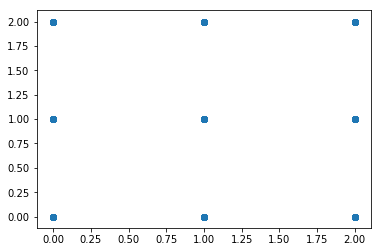

In [84]:
import matplotlib.pyplot as plt
plt.scatter(x_test['y_true'], x_test['y_predict'])
plt.show()
#plt.savefig('/Users/robmarty/Desktop/books_read1111aaaakdsfhlkasdfklasdjfkajf.png')

(3412,)

(1463,)

In [111]:
r2_score(y_true=y_test, y_pred=pred_labels) 

-1.3808505675231526

In [122]:
#pred_labels.shape
#y_test

1840    120000.0  
4113    70000.0   
1748    54800.0   
5042    48000.0   
5169    150000.0  
603     18000.0   
3948    120000.0  
1426    78800.0   
5172    40000.0   
4887    108000.0  
4099    55000.0   
3433    40000.0   
2871    96000.0   
520     54000.0   
5080    36000.0   
4016    35000.0   
4779    55000.0   
3682    0.0       
3173    80400.0   
323     72000.0   
1997    130000.0  
2272    36000.0   
828     140000.0  
3801    120000.0  
1500    38900.0   
2504    37500.0   
2529    30000.0   
1528    64600.0   
635     24000.0   
712     125000.0  
          ...     
1754    50000.0   
1453    0.0       
5161    55000.0   
404     106000.0  
3097    48000.0   
4285    121000.0  
189     204000.0  
4740    60000.0   
4975    145000.0  
5269    25000.0   
3468    76000.0   
1004    48000.0   
4011    66000.0   
2511    90000.0   
1875    70000.0   
4256    1064999.0 
1918    35300.0   
3916    72000.0   
4637    10044999.0
5271    40000.0   
4055    85000.0   
703     8100

In [147]:
y_test[1:10]


array([  7200.        ,  42900.        ,  94000.        ,  77000.        ,
       180000.        ,  79765.74193548,  60000.        ,  51000.        ,
        43000.        ])

In [149]:
pred_labels = i.regressor.predict(x_test[features])
pred_labels[1:10]

array([  7200.        ,  42900.        ,  94000.        ,  77000.        ,
       180000.        ,  79765.74193548,  60000.        ,  51000.        ,
        43000.        ])

In [ ]:
cf.GRID_TEST